# 04 Case Study

## General Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import chaospy as cp
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.contour import QuadContourSet
from scipy.interpolate import griddata

from helper_functions import (
   get_joint,
   setup_plot,
   store_plot,
   optimize_facetgrid_titles,
   print_dimensions
)

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="bright")
bright_palette = sns.color_palette("bright")

## Functions

### Data Handling

In [3]:
def get_training_data(data, num_samples, num_replications, target, moment='mean'):
    """
    Retrieves training data subset and computes statistics for the target variable.

    Args:
        data (DataFrame): Input dataset.
        num_samples (int): Number of unique samples.
        num_replications (int): Number of replications per sample.
        target (str): Target variable ('Tower_Sdv', 'Tower_Max', 'Blade_Mean', 'Blade_Max').
        moment (str, optional): Statistic to compute ('mean' or 'sdv'). Defaults to 'mean'.

    Returns:
        numpy.ndarray: Feature matrix.
        pandas.Series: Target values.
    """

    target_mapping = {
        'Tower_Sdv': 'TwHtALxt_[m/s^]_sdv',
        'Tower_Max': 'TwHtALxt_[m/s^]_max',
        'Blade_Mean': 'RootMyb_[kN-m]_mean',
        'Blade_Max': 'RootMyb_[kN-m]_max'
    }
    target = target_mapping.get(target, None)
    filtered_df = pd.DataFrame()
    unique_samples = data.iloc[0:num_samples, 0:4]

    for i in range(len(unique_samples)):
        # Calculate the starting and ending row indices for each feature combination
        idx_list = [i+j*300 for j in range(num_replications)]
        temp_df = data.iloc[idx_list, :]
        # Append the extracted rows to the filtered DataFrame
        filtered_df = pd.concat([filtered_df, temp_df])
    clean_df = filtered_df.dropna(how='any', axis=0)

    if len(filtered_df) - len(clean_df) == 0:
        pass
    else:
        print(
            f"{len(filtered_df) - len(clean_df)} rows were removed from the training data")

    if num_replications > 1:
        if moment == 'mean':
            clean_df = clean_df.groupby(list(clean_df.columns[0:4]))[
                target].mean().reset_index()
        elif moment == 'sdv':
            clean_df = clean_df.groupby(list(clean_df.columns[0:4]))[
                target].std().reset_index()

    x_train = clean_df.iloc[:, 0:4]
    y_train = clean_df.loc[:, target]
    x_train = np.array(x_train).T

    return x_train.T, y_train

def load_sim_data(ipath, case_matrix, case_data):
    """
    Load and combine simulation data from case matrix and case data files.

    Args:
        ipath (str): Directory path to the data files.
        case_matrix (str): Filename of the case matrix CSV file.
        case_data (str): Filename of the case data CSV file.

    Returns:
        pandas.DataFrame: Combined DataFrame of cases and case data.
    """
    case_matrix_path = os.path.join(ipath, case_matrix)
    case_data_path = os.path.join(ipath, case_data)
    cases = pd.read_csv(case_matrix_path)
    case_data = pd.read_csv(case_data_path).sort_values(
        by=['Case']).reset_index(drop=True)
    return pd.concat([cases, case_data], axis=1)

def load_models(model):
    """
    Load saved PCE or GPR models from pickle files.

    Args:
        model (str): Type of model to load ('pce' or 'gpr').

    Returns:
        object: Loaded model from the pickle file.
    """

    base_path = os.path.join(os.path.dirname(os.getcwd()), r"data\models")
    if model == "pce":
        with open(os.path.join(base_path, 'pce_models.pickle'), 'rb') as handle:
            return pickle.load(handle)
    elif model == "gpr":
        with open(os.path.join(base_path, 'gpr_models.pickle'), 'rb') as handle:
            return pickle.load(handle)

def batch_process_fwd_transformation(data, distribution, batch_size=100000):
    """
    Apply forward transformation to data in batches to handle memory constraints.

    Args:
        data (numpy.ndarray): Input data array [n_features, n_samples].
        distribution: Distribution object.
        batch_size (int, optional): Number of samples to process per batch. Defaults to 100000.

    Returns:
        numpy.ndarray: Transformed data with same shape as input.
    """
    # Initialize an empty array to store normalized data
    normalized_data = np.empty_like(data)

    # Process in batches
    for start in range(0, data.shape[1], batch_size):
        end = start + batch_size
        print(end)
        batch_data = data[:, start:end]
        normalized_batch = distribution.fwd(batch_data)
        normalized_data[:, start:end] = normalized_batch

    return normalized_data

def find_problematic_samples(data, distribution, start, end):
    """
    Identifies all problematic samples that cause an error during the forward
    transformation of the data using a binary search algorithm. The function 
    narrows down the search range to isolate problematic samples and checks 
    each sample individually within the identified ranges.

    Args:
        data (numpy.ndarray): The dataset to be transformed.
        distribution (Distribution): The chaospy distribution object used for the transformation.
        start (int): The starting index of the range to search within the dataset.
        end (int): The ending index of the range to search within the dataset.

    Returns:
        list: Indices of all problematic samples within the specified range.
    """
    problematic_indices = []

    def binary_search(start, end):
        if start >= end:  # No range left to search
            return
        if end - start == 1:  # Single sample case
            try:
                distribution.fwd(data[:, start:end])
            except Exception as e:
                problematic_indices.append(start)
            return

        # Check the midpoint
        mid = (start + end) // 2
        try:
            distribution.fwd(data[:, start:mid])  # Check the first half
        except Exception:
            # Recursively search the problematic half
            binary_search(start, mid)

        try:
            distribution.fwd(data[:, mid:end])  # Check the second half
        except Exception:
            binary_search(mid, end)  # Recursively search the problematic half

    # Start the binary search
    binary_search(start, end)

    return problematic_indices

def eval_pce(model_approx, q0, q1, q2, q3):
    """
    Evaluate the Polynomial Chaos Expansion (PCE) model approximation for given parameter values.

    Args:
        model_approx: The PCE model approximation object from chaospy library.
        q0 (array-like): Values for the first input parameter of the PCE model.
        q1 (array-like): Values for the second input parameter of the PCE model.
        q2 (array-like): Values for the third input parameter of the PCE model.
        q3 (array-like): Values for the fourth input parameter of the PCE model.

    Returns:
        numpy.ndarray: The evaluated values of the PCE model for the provided parameters.
    """
    if any([i in str(model_approx) for i in ['q0', 'q1', 'q2', 'q3']]):
        return eval(str(model_approx), {'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3})
    else:
        return np.array([eval(str(model_approx)) for _ in range(len(q0))])

def get_blade_mean(df):
    """
    Calculate average blade loads and filter data for blade analysis.

    Args:
        df (pandas.DataFrame): Input DataFrame containing blade load columns.

    Returns:
        pandas.DataFrame: DataFrame with:
            - Averaged min, max, sdv, and avg loads across all blades
            - Rows with negative average loads removed
            - Individual blade load columns removed
    """
    df_cp = df.copy()
    df_cp["Load on blades (min.)"] = -1*df_cp.loc[:, df_cp.columns.str.contains(
        r"Load on blade \d+ \(min.\)", regex=True)].mean(axis=1)
    df_cp["Load on blades (max.)"] = -1*df_cp.loc[:, df_cp.columns.str.contains(
        r"Load on blade \d+ \(max.\)", regex=True)].mean(axis=1)
    df_cp["Load on blades (sdv.)"] = df_cp.loc[:, df_cp.columns.str.contains(
        r"Load on blade \d+ \(sdv.\)", regex=True)].mean(axis=1)
    df_cp["Load on blades (avg.)"] = -1*df_cp.loc[:, df_cp.columns.str.contains(
        r"Load on blade \d+ \(avg.\)", regex=True)].mean(axis=1)
    
    avg_load_columns = df_cp.columns.str.contains(r"Load on blade \d+ \(avg.\)", regex=True)
    rows_with_negative_avg_load = df_cp.loc[:, avg_load_columns].gt(0).any(axis=1)
    # Exclude rows with negative avg. load
    df_cp = df_cp[~rows_with_negative_avg_load]

    df_cp = df_cp.loc[:, ~df_cp.columns.str.contains(
        r"Load on blade \d+", regex=True)]
    return df_cp

def save_dataframes(dataframes, filename):
    """
    Save DataFrames to a pickle file.

    Args:
        dataframes: DataFrame or list of DataFrames to save.
        filename (str): Path where to save the pickle file.
    """
    with open(filename, 'wb') as file:
        pickle.dump(dataframes, file)
        
def load_dataframes(filename):
    """
    Load DataFrames from a pickle file.

    Args:
        filename (str): Path to the pickle file.

    Returns:
        DataFrame or list of DataFrames that were saved in the file.
    """
    with open(filename, 'rb') as file:
        dataframes = pickle.load(file)
    return dataframes

def get_training_sdv(target):
    """
    Load and process simulation data to create training dataset with standard deviation values.

    Args:
        target (str): Target variable to extract ('Tower_Sdv', 'Tower_Max', 'Blade_Mean', 'Blade_Max').

    Returns:
        pandas.DataFrame: Training dataset with wind speed, TI, air density, wind direction, and target SDV.
    """
    df = load_sim_data(input_path_sim, 'casematrix.csv', 'surrogate_data.csv')
    df_train = df.iloc[0:9000, :]
    x, y = get_training_data(df_train, 300, 30, target, moment='sdv')
    df = pd.DataFrame(x, columns=[COLUMN_WIND_SPEED_AVG, COLUMN_TI_EST, COLUMN_AIR_DENSITY_AVG, COLUMN_RELATIVE_WIND_DIRECTION_AVG])
    df[target] = y
    return df

def get_training_mean(target):
    """
    Load and process simulation data to create training dataset with mean values.

    Args:
        target (str): Target variable to extract ('Tower_Sdv', 'Tower_Max', 'Blade_Mean', 'Blade_Max').

    Returns:
        pandas.DataFrame: Training dataset with wind speed, TI, air density, wind direction, and target mean.
    """
    df = load_sim_data(input_path_sim, 'casematrix.csv', 'surrogate_data.csv')
    df_train = df.iloc[0:9000, :]
    x, y = get_training_data(df_train, 300, 30, target, moment='mean')
    df = pd.DataFrame(x, columns=[COLUMN_WIND_SPEED_AVG, COLUMN_TI_EST, COLUMN_AIR_DENSITY_AVG, COLUMN_RELATIVE_WIND_DIRECTION_AVG])
    df[target] = y
    return df

def long_to_wide(df, column, value):
    """
    Convert DataFrame from long to wide format based on specified column.

    Args:
        df (DataFrame): Input DataFrame in long format.
        column (str): Column to pivot into multiple columns.
        value (str): Column containing values to populate wide format.

    Returns:
        DataFrame: Reshaped DataFrame in wide format.
    """
    df_new = df.copy()
    df_new.reset_index(drop=True, inplace=True)
    df_new = pd.DataFrame()
    for error in df[column].unique():
        df_temp = df.loc[df[column] == error]
        df_temp.drop(columns=[column], inplace=True)
        df_temp.rename(columns={value: error}, inplace=True)
        if df_new.empty:
            df_new = df_temp.copy()
        else:
            df_new = pd.merge(left=df_new, right=df_temp, how='outer')
    df_new.reset_index(inplace=True, drop=True)
    return df_new

### Plotting

In [4]:
def error_stats_merge(df1, df2):
    """
    Create a 2x2 subplot comparing mean and median relative errors across turbines.

    Args:
        df1 (pandas.DataFrame): First DataFrame.
        df2 (pandas.DataFrame): Second DataFrame.
    """

    WIDTH, HEIGHT = setup_plot(0.7)
    WIDTH *= .8
    HEIGHT *= .8
    error_stats1 = df1.groupby(['turbine', 'variable'])['value'].agg(['mean', 'median']).reset_index().copy()
    error_stats2 = df2.groupby(['turbine', 'variable'])['value'].agg(['mean', 'median']).reset_index().copy()

    mapping_dict = {
    'Relative Error Blade_Max': '$M_{\mathrm{blade,max}}$',
    'Relative Error Blade_Mean': '$M_{\mathrm{blade,mean}}$',
    'Relative Error Tower_Max': '$\ddot{x}_{\mathrm{tower,max}}$',
    'Relative Error Tower_Sdv': '$\ddot{x}_{\mathrm{tower,std}}$'
    }

    error_stats1.variable = [mapping_dict[name] for name in error_stats1.variable]
    error_stats2.variable = [mapping_dict[name] for name in error_stats2.variable]
    
    # Set up the matplotlib figure with four subplots arranged in 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(WIDTH, HEIGHT), sharex='col', sharey=False)

    # Plot mean errors for df1
    sns.barplot(x='variable', y='mean', hue='turbine', data=error_stats1, ax=axes[0, 0], edgecolor='black', width=.8)
    #axes[0, 0].set_title('Mean Error for Blade Loads')
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('Mean Relative Error [-]')

    # Plot median errors for df1
    sns.barplot(x='variable', y='median', hue='turbine', data=error_stats1, ax=axes[1, 0], edgecolor='black', width=.8)
    #axes[1, 0].set_title('Median Error for Blade Loads')
    axes[1, 0].set_xlabel('Target')
    axes[1, 0].set_ylabel('Median Relative Error [-]')

    # Plot mean errors for df2
    sns.barplot(x='variable', y='mean', hue='turbine', data=error_stats2, ax=axes[0, 1], edgecolor='black', width=.8)
    #axes[0, 1].set_title('Mean Error for Tower Acceleration')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('Mean Relative Error [-]')

    # Plot median errors for df2
    sns.barplot(x='variable', y='median', hue='turbine', data=error_stats2, ax=axes[1, 1], edgecolor='black', width=.8)
    #axes[1, 1].set_title('Median Error for Tower Acceleration')
    axes[1, 1].set_xlabel('Target')
    axes[1, 1].set_ylabel('Median Relative Error [-]')

    # Remove legends created by seaborn from individual plots
    for ax in axes.flatten():
        ax.get_legend().remove()

    # Create a single shared legend for both columns
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=8, title='Turbine', frameon=False)
    fig.align_labels()

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=.2, wspace=.3)

    #store_plot(fig, 'merged_error_stats.png')
    
def error_grid(df1, df2):
    """
    Create a faceted grid plot showing error trends over years for different variables.

    Args:
        df1 (pandas.DataFrame): First DataFrame.
        df2 (pandas.DataFrame): Second DataFrame.
    """
    df_func = pd.concat([df1, df2], axis=0)
    df_func = df_func.groupby(['turbine', 'year', 'variable'])['value'].agg(['mean', 'median']).reset_index()
    df_func2 = pd.melt(df_func, id_vars=['turbine', 'year', 'variable'], value_vars=['mean', 'median'], var_name='metric')
    FIG_WIDTH, FIG_HEIGHT = setup_plot(height_ratio=.6)
    
    mapping_dict = {
        'Relative Error Blade_Max': '$M_{\mathrm{blade,max}}$',
        'Relative Error Blade_Mean': '$M_{\mathrm{blade,mean}}$',
        'Relative Error Tower_Max': '$\ddot{x}_{\mathrm{tower,max}}$',
        'Relative Error Tower_Sdv': '$\ddot{x}_{\mathrm{tower,std}}$'
    }
    df_func2.variable = [mapping_dict[name] for name in df_func2.variable]
    df_func2.rename(columns={'value': 'Relative Error [-]'}, inplace=True)
    
    mapping_metric = {
        'mean': 'Mean',
        'median': 'Median'
    }
    df_func2.metric = [mapping_metric[name] for name in df_func2.metric]

    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/4
    g = sns.FacetGrid(df_func2, col="variable", row="metric", hue='turbine',
                    margin_titles=True, sharey=False, height=sub_height,
                    aspect=sub_width /sub_height)
    g.map_dataframe(sns.lineplot, x='year', y='Relative Error [-]', palette=bright_palette)
    g = optimize_facetgrid_titles(g)
    g.add_legend(loc='upper center', bbox_to_anchor=(0.35, -0.05), ncol=8, title='Turbine', frameon=False)
    for ax in g.axes.flatten():
        ax.set_xlabel('Year')
    #store_plot(g, 'error_year_plot.png')

def stat_grid(df, cols):
    """
    Create a faceted grid plot showing mean and median trends over years for selected columns.

    Args:
        df (pandas.DataFrame): Input data.
        cols (list): Column names to analyze (blade loads and tower oscillations).
    """

    df_func = df.copy()
    stats = df_func.groupby(['turbine', 'year'])[cols].agg(['mean', 'median']).reset_index()
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    long_df = stats.melt(id_vars=['year_', 'turbine_'], var_name='target_metric', value_name='value')
    long_df[['target', 'metric']] = long_df['target_metric'].str.split('_', expand=True)
    long_df = long_df.drop('target_metric', axis=1)
    long_df.rename(columns={'year_': 'year', 'turbine_': 'turbine'}, inplace=True)
    long_df.rename(columns={'value': 'Value'}, inplace=True)
    
    mapping = {
        'Load on blades (avg.)': '$M_{\mathrm{blade,mean}}$ [Nm]',
        'Load on blades (min.)': '$M_{\mathrm{blade,max}}$ [Nm]',
        'Tower oscillation level X (sdv.) [mm/s²]': '$\ddot{x}_{\mathrm{tower,std}}$ [mm/s$^2$]',
        'Tower oscillation level X (max.) [mm/s²]': '$\ddot{x}_{\mathrm{tower,max}}$ [mm/s$^2$]'
    }
    
    long_df.target = [mapping[name] for name in long_df.target]
    mapping_metric = {
        'mean': 'Mean',
        'median': 'Median'
    }
    long_df.metric = [mapping_metric[name] for name in long_df.metric]

    
    FIG_WIDTH, FIG_HEIGHT = setup_plot(height_ratio=.7)
    
    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/4
    g = sns.FacetGrid(long_df, col="target", row="metric", hue='turbine',
                    margin_titles=True, sharey=False, height=sub_height,
                    aspect=sub_width /sub_height)
    g.map_dataframe(sns.lineplot, x='year', y='Value', palette=bright_palette)
    g = optimize_facetgrid_titles(g)
    g.add_legend(loc='upper center', bbox_to_anchor=(0.33, -0.02), ncol=8, title='Turbine', frameon=False)
    for ax in g.axes.flatten():
        ax.set_title(ax.get_title(), y=1.05, fontsize=8)
        ax.set_xlabel('Year')

    #store_plot(g, 'scada_year_plot.png')

def corr_plots(df):
    """
    Create correlation heatmaps between error metrics and environmental variables for each turbine.

    Args:
        df (DataFrame): Input data with error metrics and environmental variables.

    Returns:
        matplotlib.figure.Figure: Figure containing correlation heatmaps.
    """
    df_corr = df.copy()
    df_corr = df_corr.drop(columns=['year'])

    mapping_dict = {
        'Relative Error Blade_Max': 'Relative Error $M_{\mathrm{blade,max}}$',
        'Relative Error Blade_Mean': 'Relative Error $M_{\mathrm{blade,mean}}$',
        'Relative Error Tower_Max': 'Relative Error $\ddot{x}_{\mathrm{tower,max}}$',
        'Relative Error Tower_Sdv': 'Relative Error $\ddot{x}_{\mathrm{tower,std}}$',
        'TI_est': 'Turbulence Intensity [-]',
        'Wind speed (avg.) [m/s]': 'Wind Speed [m/s]',
        'Air Density [kg/m3]': 'Air Density [kg/m$^3$]',
        'Relative wind direction (wind shear) (avg.) [°]': 'Yaw Misalignment Angle [°]',
        'Wind direction (avg.) [°]': 'Wind Direction [°]'
    }
    
    df_corr.rename(columns=mapping_dict, inplace=True)
    # Get unique turbines
    turbines = df_corr['turbine'].unique()
    width, _ = setup_plot()
    # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(
        width, width*0.8), sharex='col', sharey='row')
    axes = axes.flatten()
    
    vmax = df_corr.corr().to_numpy().max()
    vmin = df_corr.corr().to_numpy().min()
    
    for i, turbine in enumerate(turbines):
        # Filter data by turbine
        df_turbine = df_corr[df_corr['turbine'] == turbine]
        df_turbine.drop(columns=['turbine'], inplace=True)
        # Compute correlation matrix
        corr_matrix = df_turbine.corr()
        corr_matrix = corr_matrix.iloc[:-4, -4:]
        # Plot heatmap
        ax = axes[i]
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr_matrix, vmax=vmax, vmin=vmin, center=0, annot=True,
                    fmt=".2f", cmap=cmap, ax=ax, square=True, linewidths=.7,
                    cbar=False)
        ax.set_title(f'Turbine {turbine}')
    
    plt.tight_layout()
    #store_plot(fig, 'correlation_plot.png')
    return fig

def plot_target(df, turbine=2):
    """
    Create a 4x4 grid comparing predicted vs measured values across targets and features.

    Args:
        df (DataFrame): Input data.
        turbine (int, optional): Turbine ID to plot. If None, plots all turbines. Defaults to 2.
    """
    mapping = {
        'Blade_Mean': 'Load on blades (avg.)',
        'Blade_Max': 'Load on blades (min.)', 
        'Tower_Sdv': 'Tower oscillation level X (sdv.) [mm/s²]',
        'Tower_Max': 'Tower oscillation level X (max.) [mm/s²]'
    }
    
    mapping_features = {'Wind speed (avg.) [m/s]': 'Wind Speed [m/s]',
                        'TI_est': 'Turbulence Intensity [-]',
                        'Air Density [kg/m3]': 'Air Density [kg/$m^3$]',
                        'Relative wind direction (wind shear) (avg.) [°]': 'Yaw Misalignment Angle [°]'}
    
    mapping_target = {
        'Blade_Mean': '$M_{\mathrm{blade,mean}}$ [Nm]',
        'Blade_Max': '$M_{\mathrm{blade,max}}$ [Nm]',
        'Tower_Sdv': '$\ddot{x}_{\mathrm{tower,std}}$ [mm/s$^2$]',
        'Tower_Max': '$\ddot{x}_{\mathrm{tower,max}}$ [mm/s$^2$]'
    }
    
    # Assuming `setup_plot` returns figure dimensions
    WIDTH, HEIGHT = setup_plot(1)
    fig, axes = plt.subplots(4, 4, figsize=(WIDTH, HEIGHT), sharey='row', sharex='col')  # 4x4 subplots for 4 targets and 4 features
    targets = list(mapping.keys())
    features = df.columns[0:4]  # Assumes the first 4 columns are features
    for i, target in enumerate(targets):
        if turbine is not None:
            query = f"turbine=={str(turbine)}"
            df_scada_plot = df.query(query).copy()
        else:
            df_scada_plot = df.copy()
        df_scada_plot = df_scada_plot.sample(frac=0.00018, replace=True, random_state=1)
        df_scada_plot = df_scada_plot.loc[df_scada_plot[f"{target}_Sdv_Prediction"]>0, :]

        for j, feature in enumerate(features):
            ax = axes[i][j]  # Row for target, column for feature
            x = df_scada_plot[feature]
            y = df_scada_plot[f"{target}_Mean_Prediction"]
            y_true = df_scada_plot[mapping[target]]
            error = df_scada_plot[f"{target}_Sdv_Prediction"]
            min_val, max_val = x.min(), x.max()
            # Filter the training data based on the feature's range in sampled data
            training_data = get_training_mean(target)
            training_data_filtered = training_data[(training_data[feature] >= min_val) & (training_data[feature] <= max_val)]
            y_train = training_data_filtered[target]*1e3
            x_train = training_data_filtered[feature]
            ax.errorbar(x, y, yerr=error, fmt='.', color=bright_palette[0], ecolor=bright_palette[3], alpha=0.4, capsize=4, label='Predicted')
            ax.scatter(x, y_true, color='k', alpha=.8, s=4, label='Measured')
            ax.scatter(x_train, y_train, color=bright_palette[2], alpha=.8, s=2, label='Training')
            ax.set_ylim(0.99*y_true.min(), 1.01*y_true.max())

            if i==3:
                ax.set_xlabel(mapping_features[feature])
                ax.set_ylim(df_scada_plot[f"{target}_Mean_Prediction"].min(), 2000)
            if j==0:
                ax.set_ylabel(mapping_target[target])
    for ax in axes.flat:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            legend_handles, legend_labels = handles, labels
            break  # Assuming all subplots have the same legend info, we break after getting the first


    fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)
    fig.align_labels()
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    #store_plot(fig, "all_targets_prediction_plot.png")

def plot_windspeed_histograms(df, col):
    """
    Create histograms of wind speed distribution for each turbine.

    Args:
        df (DataFrame): Input data.
        col (str): Column name to plot histograms for.
    """
    WIDTH, HEIGHT = setup_plot(.5)

    turbines = df['turbine'].unique()

    # Create a 4x2 subplot grid
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(WIDTH, HEIGHT))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Plot a histogram for each turbine
    for i, turbine in enumerate(turbines):
        if i < 8:  # To avoid IndexError if there are more than 8 turbines
            # Filter the dataframe for the current turbine
            turbine_df = df[df['turbine'] == turbine]

            # Plot histogram
            sns.histplot(turbine_df[col], ax=axes[i], kde=False, stat='percent', bins=40)

            # Calculate mean and median
            mean = turbine_df[col].mean()
            #median = turbine_df[COLUMN_WIND_SPEED_AVG].median()

            # Plot and annotate mean and median
            axes[i].axvline(mean, color=bright_palette[3], linestyle='--')
            axes[i].text(mean, 0.9*axes[i].get_ylim()[1], f'Mean: {mean:.2f}', color=bright_palette[3])

            #axes[i].axvline(median, color='red', linestyle='--')
            #axes[i].text(median, 0.8*axes[i].get_ylim()[1], f'Median: {median:.2f}', rotation=90, color='red')

            # Set title
            axes[i].set_title(f'Turbine {turbine}')

    # Remove any unused subplots
    for j in range(i + 1, 8):
        fig.delaxes(axes[j])

    plt.tight_layout()

def timeline(df, col1):
    """
    Create timeline plot showing median wind speed trends by turbine over years.

    Args:
        df (DataFrame): Input data.
        col1 (str): Wind speed column name.
    """
    WIDTH, HEIGHT = setup_plot(0.6)
    # Set up the matplotlib figure with a grid of subplots
    fig, axes = plt.subplots(figsize=(.8*WIDTH, .8*HEIGHT))

    # Group by 'turbine', 'year' and calculate mean and median for the first column
    stats1 = df.groupby(['turbine', 'year'])[col1].agg(['mean', 'median']).reset_index()
    # Plot mean for the first column in the first row, first column of subplots
    sns.lineplot(x='year', y='median', hue='turbine', data=stats1, ax=axes, marker='o', palette='bright')
    axes.set_ylabel(f'Mean of Wind Speed [m/s]')
    axes.set_xlabel(f'Year')

    axes.get_legend().remove()

    # Create a single shared legend
    handles, labels = axes.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.014), ncol=len(handles), title='Turbine', frameon=False)

    # Adjust layout
    plt.tight_layout()
    #store_plot(fig, f"timeline_wsp")
    
def create_heatmap(df1, df2):
    """
    Create interpolated heatmaps showing error distributions across turbine locations.

    Args:
        df1 (DataFrame): First set of error statistics.
        df2 (DataFrame): Second set of error statistics.
    """
    # Concatenating dataframes
    df = pd.concat([df1, df2], axis=0)
    error_stats = df.groupby(['turbine', 'variable'])['value'].agg(['mean', 'median']).reset_index()

    # Define coordinates
    coords = {} # Anonymized

    coords_df = pd.DataFrame.from_dict(coords, orient='index', columns=['Latitude', 'Longitude'])
    coords_df['x'] = (coords_df['Longitude'] - coords_df['Longitude'].min()) / (coords_df['Longitude'].max() - coords_df['Longitude'].min())
    coords_df['y'] = (coords_df['Latitude'] - coords_df['Latitude'].min()) / (coords_df['Latitude'].max() - coords_df['Latitude'].min())
    coords_df['turbine'] = coords_df.index.astype(int)
    error_stats = error_stats.merge(coords_df, on='turbine')
    error_stats.drop(columns=['Latitude', 'Longitude'], inplace=True)
    error_stats.rename(columns={'variable': 'target'}, inplace=True)
    # Melting the data for FacetGrid
    error_stats_melted = error_stats.melt(id_vars=['turbine', 'target', 'x', 'y'], value_vars=['mean', 'median'])
    
    mapping_dict = {
        'Relative Error Blade_Max': '$M_{\mathrm{blade,max}}$',
        'Relative Error Blade_Mean': '$M_{\mathrm{blade,mean}}$',
        'Relative Error Tower_Max': '$\ddot{x}_{\mathrm{tower,max}}$',
        'Relative Error Tower_Sdv': '$\ddot{x}_{\mathrm{tower,std}}$'
    }
    
    mapping_metric = {
        'mean': 'Mean',
        'median': 'Median'
    }
    error_stats_melted.target = [mapping_dict[name] for name in error_stats_melted.target]
    error_stats_melted.variable = [mapping_metric[name] for name in error_stats_melted.variable]


    def plot_heatmap(data, col_name, **kwargs):
        """
        Create a single interpolated heatmap panel with turbine locations.

        Args:
            data (DataFrame): Data containing coordinates and values.
            col_name (str): Column name containing values to plot.
            **kwargs: Additional keyword arguments.
        """

        # Create grid coordinates for interpolation
        xi = np.linspace(data['x'].min(), data['x'].max(), 100)
        yi = np.linspace(data['y'].min(), data['y'].max(), 100)
        xi, yi = np.meshgrid(xi, yi)

        # Interpolate z values on grid
        zi = griddata((data['x'], data['y']), data[col_name], (xi, yi), method='linear')

        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        # Contour plot
        plt.contourf(xi, yi, zi, cmap=cmap, norm='log')
        plt.scatter(data['x'], data['y'], c='k', label='Turbine Locations')
        
        padding_factor = 0.1

        # Calculate the range of your data and apply padding
        x_range = np.ptp(error_stats['x'])  # Peak to peak (max - min) for 'x'
        y_range = np.ptp(error_stats['y'])  # Peak to peak (max - min) for 'y'

        # Apply padding to the limits
        x_padding = x_range * padding_factor
        y_padding = y_range * padding_factor

        plt.xlim([error_stats['x'].min() - x_padding, error_stats['x'].max() + x_padding])
        plt.ylim([error_stats['y'].min() - y_padding, error_stats['y'].max() + y_padding])

    
    FIG_WIDTH, FIG_HEIGHT = setup_plot(height_ratio=.5)
    
    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/4
    g = sns.FacetGrid(error_stats_melted, col="target", row="variable",
                    margin_titles=True, sharey=False, height=sub_height,
                    aspect=sub_width /sub_height)

    g.map_dataframe(plot_heatmap, col_name='value')
    
    last_contour_set = None
    for ax in g.axes.flat:
        for contour_set in ax.collections:
            if isinstance(contour_set, QuadContourSet):
                last_contour_set = contour_set    
    fig = plt.gcf()
    cbar_ax = fig.add_axes([0.25, -0.1, 0.5, 0.02])
    fig.colorbar(last_contour_set, cax=cbar_ax, orientation='horizontal', cmap=sns.diverging_palette(230, 20, as_cmap=True),
                label='Normalized Relative Error')

    
    # Adjust layout and show plot
    g.set_axis_labels('Normalized Longitude', 'Normalized Latitude')
    g = optimize_facetgrid_titles(g)
    for ax in g.axes.ravel():
        for _, row in coords_df.iterrows():
            ax.annotate(int(row['turbine']), (row['x'], row['y']), textcoords="offset points", xytext=(0, 5), ha='center', size=7)
    #store_plot(g, 'heatmap_merge.png')
    print_dimensions(g)
    
def hour_plot(df1, df2):
    """
    Create a faceted grid showing error trends over hours of the day.

    Args:
        df1 (DataFrame): First set of error statistics.
        df2 (DataFrame): Second set of error statistics.
    """

    df_func = pd.concat([df1, df2], axis=0)
    df_func = df_func.groupby(['turbine', 'Hour', 'variable'])['value'].agg(['mean', 'median']).reset_index()
    df_func2 = pd.melt(df_func, id_vars=['turbine', 'Hour', 'variable'], value_vars=['mean', 'median'], var_name='metric')
    FIG_WIDTH, FIG_HEIGHT = setup_plot(height_ratio=.6)
    
    mapping_dict = {
        'Relative Error Blade_Max': '$M_{\mathrm{blade,max}}$',
        'Relative Error Blade_Mean': '$M_{\mathrm{blade,mean}}$',
        'Relative Error Tower_Max': '$\ddot{x}_{\mathrm{tower,max}}$',
        'Relative Error Tower_Sdv': '$\ddot{x}_{\mathrm{tower,std}}$'
    }
    df_func2.variable = [mapping_dict[name] for name in df_func2.variable]
    df_func2.rename(columns={'value': 'Relative Error [-]'}, inplace=True)
    
    mapping_metric = {
        'mean': 'Mean',
        'median': 'Median'
    }
    df_func2.metric = [mapping_metric[name] for name in df_func2.metric]

    sub_height = FIG_HEIGHT/2
    sub_width = FIG_WIDTH/4
    g = sns.FacetGrid(df_func2, col="variable", row="metric", hue='turbine',
                    margin_titles=True, sharey=False, height=sub_height,
                    aspect=sub_width /sub_height)
    g.map_dataframe(sns.lineplot, x='Hour', y='Relative Error [-]', palette=bright_palette)
    g = optimize_facetgrid_titles(g)
    g.add_legend(loc='upper center', bbox_to_anchor=(0.33, -0.024), ncol=8, title='Turbine', frameon=False)
    #store_plot(g, 'hour_plot.png')
    
def plot_error_significance(df1, df2, targets):
    """
    Create histograms of z-scores to analyze error significance for each target.

    Args:
        df1 (DataFrame): First set of error statistics.
        df2 (DataFrame): Second set of error statistics.
        targets (list): List of target variables to analyze.
    """

    # Set up the plot
    WIDTH, HEIGHT = setup_plot(1)
    WIDTH *=.9
    HEIGHT *=.9
    fig, axes = plt.subplots(2, 2, figsize=(WIDTH, HEIGHT))  # Adjust size as needed
    axes = axes.flatten()  # Flatten the 2x2 grid for easy indexing

    for i, target in enumerate(targets):
        ax = axes[i]

        # Select the appropriate dataframe based on the index
        if i < 2:  # For the first two targets
            df_func = df1.copy()
        else:  # For the last two targets
            df_func = df2.copy()

        df_func = long_to_wide(df_func, 'variable', 'value')
        mean_z = df_func[f'{target}_z-score'].median()
        
        mapping_dict = {
            'Blade_Mean': '$M_{\mathrm{blade,mean}}$ [Nm]',
            'Blade_Max': '$M_{\mathrm{blade,max}}$ [Nm]',
            'Tower_Sdv': '$\ddot{x}_{\mathrm{tower,std}}$ [mm/s$^2$]',
            'Tower_Max': '$\ddot{x}_{\mathrm{tower,max}}$ [mm/s$^2$]'
        }

        # Create the histogram plot using Z-score and bins
        sns.histplot(df_func[f'{target}_z-score'], bins=20, log_scale=(True, True), ax=ax, stat='percent')

        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
        ax.axvline(x=mean_z, color='k', linestyle='--', linewidth=2)

        # Annotate the mean Z-score
        ax.text(0.8*mean_z, ax.get_ylim()[1] * 0.6, f'Median: {mean_z:.2f}', color='k',
                ha='right', va='center', rotation=0, size=9)

        ax.set_xlabel('Z-Score')
        ax.set_ylabel('Percent')
        ax.set_title(f'{mapping_dict[target]}')

    plt.tight_layout()
    #store_plot(fig, 'z-score.png')

## Model Application

### Initial Setup

In [5]:
input_path_sim = os.path.join(os.path.dirname(os.getcwd()), r"data\simulation")
input_path_scada = os.path.join(os.path.dirname(os.getcwd()), r"data\scada")

# Constants for DataFrame column names
COLUMN_WIND_SPEED_AVG = "Wind speed (avg.) [m/s]"
COLUMN_TI_EST = "TI_est"
COLUMN_AIR_DENSITY_AVG = "Air Density [kg/m3]"
COLUMN_RELATIVE_WIND_DIRECTION_AVG = "Relative wind direction (wind shear) (avg.) [°]"
COLUMN_TURBINE = 'turbine'
COLUMN_YEAR = "year"
COLUMN_WIND_DIRECTION_AVG = 'Wind direction (avg.) [°]'
COLUMNS_BLADE = ['Load on blade 1 (avg.) []',
                'Load on blade 1 (min.) []', 'Load on blade 1 (max.) []',
                'Load on blade 1 (sdv.) []', 'Load on blade 2 (avg.) []',
                'Load on blade 2 (min.) []', 'Load on blade 2 (max.) []',
                'Load on blade 2 (sdv.) []', 'Load on blade 3 (avg.) []',
                'Load on blade 3 (min.) []', 'Load on blade 3 (max.) []',
                'Load on blade 3 (sdv.) []']

COLUMNS_TOWER = ['Tower oscillation level X (avg.) [mm/s²]',
                'Tower oscillation level X (min.) [mm/s²]',
                'Tower oscillation level X (max.) [mm/s²]',
                'Tower oscillation level X (sdv.) [mm/s²]']
CASE_SPEC_COLUMNS = [COLUMN_WIND_SPEED_AVG, COLUMN_TI_EST, COLUMN_AIR_DENSITY_AVG,
                    COLUMN_RELATIVE_WIND_DIRECTION_AVG, COLUMN_TURBINE, COLUMN_YEAR, COLUMN_WIND_DIRECTION_AVG, 'Hour']

# Define file name
filename = 'farmdata_2017-2022_refined.feather'
file_full_path = os.path.join(input_path_scada, filename)

#### Load SCADA Data

In [6]:
# Read and preprocess the data
df_scada = pd.read_feather(file_full_path)
df_scada = df_scada.loc[~df_scada.is_Abnormal]
df_scada['Hour'] = df_scada['Referenzzeitstempel'].dt.hour
df_scada = df_scada[[COLUMN_WIND_SPEED_AVG, COLUMN_TI_EST, COLUMN_AIR_DENSITY_AVG,
                    COLUMN_RELATIVE_WIND_DIRECTION_AVG, COLUMN_TURBINE, COLUMN_YEAR,  COLUMN_WIND_DIRECTION_AVG] + COLUMNS_BLADE + COLUMNS_TOWER + ['Hour']]
df_scada = get_blade_mean(df_scada)
df_scada = df_scada.loc[df_scada['Tower oscillation level X (sdv.) [mm/s²]']!=0, :].reset_index(drop=True)

#### Prepare Data for Model Processing

In [7]:
# First Setup Distribution and prepare for transforming to uniform space
x_predict = np.array(df_scada[[COLUMN_WIND_SPEED_AVG, COLUMN_TI_EST, COLUMN_AIR_DENSITY_AVG,
                     COLUMN_RELATIVE_WIND_DIRECTION_AVG]]).T
site_distribution = get_joint(input_path_scada)

# Due to the way in which the envelopes are setup, some SCADA records fall outside the bounds of the distribution and cannot be transformed. They are identified and removed
problematic_indices = find_problematic_samples(
    x_predict, site_distribution, 0, x_predict.shape[1])
mask = np.ones(x_predict.shape[1], dtype=bool)
mask[problematic_indices] = False
x_predict_cleaned = x_predict[:, mask]
print(f"{len(problematic_indices)} samples with the following indices: {problematic_indices} have been identified and removed")

# Transform the filtered SCADA Records
x_predict_norm = site_distribution.fwd(x_predict_cleaned)

# Also clean up the dataframe for later and reset the index
df_mask = ~df_scada.index.isin(problematic_indices)
df_scada = df_scada[mask].reset_index(drop=True)

5 samples with the following indices: [585054, 585071, 1204044, 1620114, 1620328] have been identified and removed


### Load Surrogates

In [8]:
pce_models = load_models('pce')
gpr_models = load_models('gpr')
targets = ["Blade_Mean", "Blade_Max", "Tower_Sdv", "Tower_Max"]
mapping = {'Blade_Mean': 'Load on blades (avg.)',
           'Blade_Max': 'Load on blades (min.)',
           'Tower_Sdv': 'Tower oscillation level X (sdv.) [mm/s²]',
           'Tower_Max': 'Tower oscillation level X (max.) [mm/s²]'}

### Perform Predictions

In [ ]:
recalc = True
output_path = os.path.join(os.path.dirname(os.getcwd()), r"data\case_study\predictions.pkl")
if recalc:
    df_scada_predict = df_scada.copy()

    for i, target in enumerate(targets):
        if target in ['Tower_Sdv', 'Tower_Max']:
            df_scada_predict[f'{target}_Mean_Prediction'] = gpr_models[target]['mean'].predict(x_predict_norm.T) * 1e3
            df_scada_predict[f'{target}_Sdv_Prediction'] = gpr_models[target]['sdv'].predict(x_predict_norm.T) * 1e3
        else:
            df_scada_predict[f'{target}_Mean_Prediction'] = eval_pce(
                pce_models[target]['mean'], x_predict_norm[0, :], x_predict_norm[1, :], x_predict_norm[2, :], x_predict_norm[3, :]) * 1e3
            df_scada_predict[f'{target}_Sdv_Prediction'] = eval_pce(
                pce_models[target]['sdv'], x_predict_norm[0, :], x_predict_norm[1, :], x_predict_norm[2, :], x_predict_norm[3, :]) * 1e3

        df_scada_predict[f'{target}_z-score'] = abs((df_scada_predict[f'{target}_Mean_Prediction'] -
                                                    df_scada_predict[mapping[target]])/(df_scada_predict[f'{target}_Sdv_Prediction']))

        print(f"Target: Any NaNs - > {any(df_scada_predict[f'{target}_z-score'].isna())}")
        if any(df_scada_predict[f'{target}_z-score'].isna()):
            pass
        df_scada_predict[f'Relative Error {target}'] = abs((df_scada_predict[f'{target}_Mean_Prediction'] -
                                                            df_scada_predict[mapping[target]])/(df_scada_predict[mapping[target]]))

    df_eval = pd.melt(df_scada_predict, id_vars=CASE_SPEC_COLUMNS,
                    value_vars=df_scada_predict.columns[df_scada_predict.columns.str.contains("Blade|Tower")])

    df_eval_error = df_eval.copy().loc[df_eval["variable"].str.contains("Error|z-score"), :]

    tower_vars = df_eval["variable"].str.contains("Tower") & df_eval["variable"].str.contains("Error|z-score")
    blade_vars = df_eval["variable"].str.contains("Blade") & df_eval["variable"].str.contains("Error|z-score")

    df_eval_tower_error_wo_z = df_eval.loc[tower_vars & ~df_eval["variable"].str.contains("z-score")]
    df_eval_blade_error_wo_z = df_eval.loc[blade_vars & ~df_eval["variable"].str.contains("z-score")]
    df_eval_tower_error = df_eval.loc[tower_vars]
    df_eval_blade_error = df_eval.loc[blade_vars]
    dfs_to_save = {'df_scada_predict': df_scada_predict, 'df_eval': df_eval, 'df_eval_tower_error_wo_z': df_eval_tower_error_wo_z, 'df_eval_blade_error_wo_z':df_eval_blade_error_wo_z,'df_eval_tower_error':df_eval_tower_error,'df_eval_blade_error':df_eval_blade_error,'df_scada':df_scada}  # A dictionary of your DataFrames
    save_dataframes(dfs_to_save, output_path)
else:
    loaded_dfs = load_dataframes(output_path)
    df_scada_predict = loaded_dfs['df_scada_predict']
    df_eval = loaded_dfs['df_eval']
    df_eval_tower_error_wo_z = loaded_dfs['df_eval_tower_error_wo_z']
    df_eval_blade_error_wo_z = loaded_dfs['df_eval_blade_error_wo_z']
    df_eval_tower_error = loaded_dfs['df_eval_tower_error']
    df_eval_blade_error = loaded_dfs['df_eval_blade_error']

Target: Any NaNs - > False
Target: Any NaNs - > False
Target: Any NaNs - > False
Target: Any NaNs - > False


### Target Overview
To visualize the results of the surrogate application, the following Figure contains a selection of randomly sampled predictions for each target. These points are overlaid with the measured SCADA records and a selection of close by training samples. The error bars serve as a visualization for the predicted standard deviation, i.e. the seed-to-seed uncertainty. While they are also included for the maximum tower acceleration, their use here is limited since the surrogate’s fit was not acceptable.

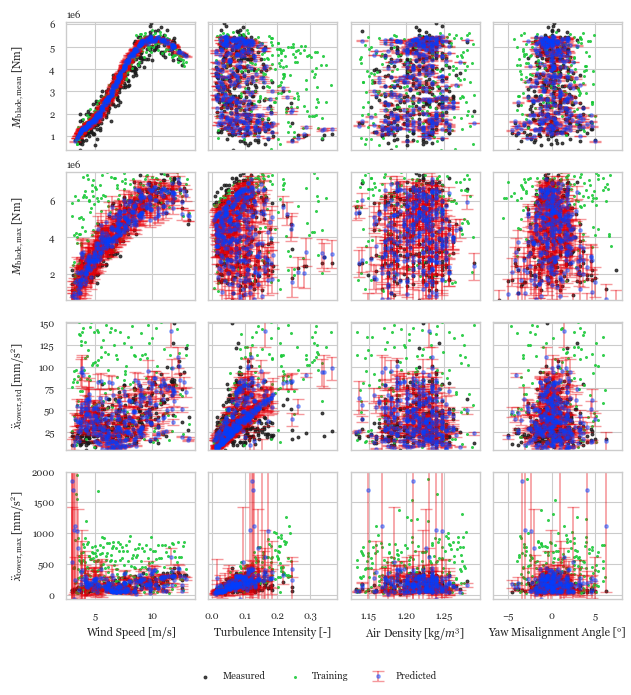

In [10]:
plot_target(df_scada_predict, turbine=None)

### Error Analysis

The following Figure provides an assessment of the mean and median prediction errors for the trained surrogate models. These are derived by computing the relative difference between the model’s predicted outputs and the actual SCADA measurements for each turbine and target. The mean and median of these relative errors are then determined to evaluate the overall model performance.

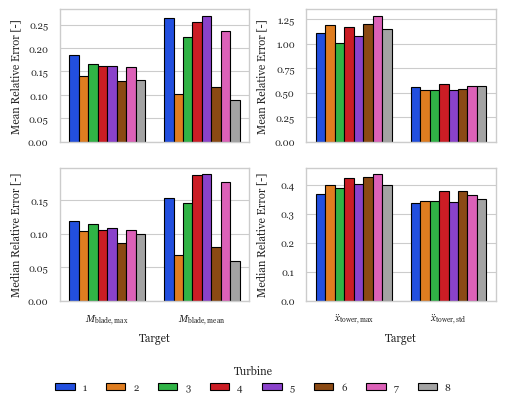

In [11]:
error_stats_merge(df_eval_blade_error_wo_z, df_eval_tower_error_wo_z)

To analyze the influence of the turbine locations, the errors from above are plotted over the farm layout. Here, the ordinate
is aligned with the north-south axis. The predominant wind direction at the farm’s location is southwest. However, the function cannot be executed in this repository since the turbine coordinates were removed to anonymize the case study. The generated figure is inserted below.

In [12]:
#create_heatmap(df_eval_blade_error_wo_z,df_eval_tower_error_wo_z)

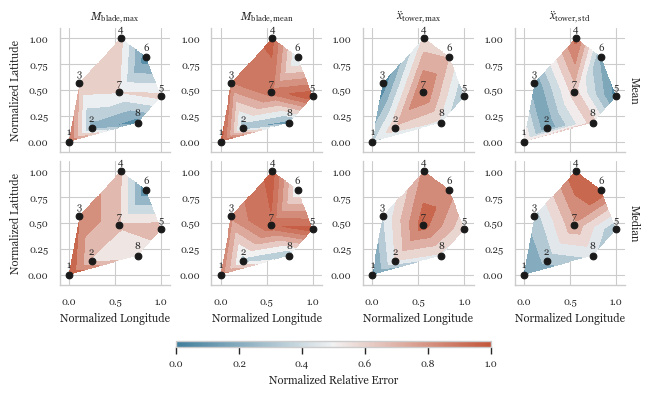

These plots visualize time dependencies of prediction errors, showing annual mean and median of the relative prediction errors for each turbine.

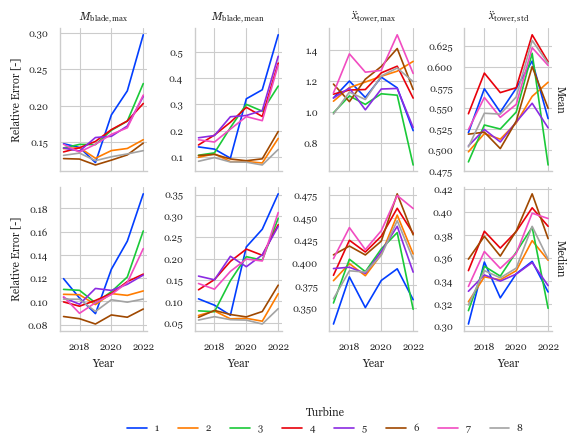

In [13]:
error_grid(df_eval_blade_error_wo_z, df_eval_tower_error_wo_z)

Annual measured loads and accelerations are summarized here to help interpret the error patterns shown above.

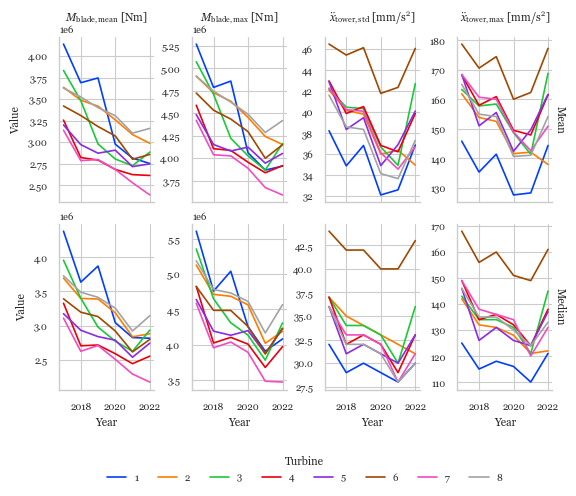

In [14]:
stat_grid(df_scada, ['Load on blades (avg.)', 'Load on blades (min.)', 'Tower oscillation level X (sdv.) [mm/s²]', 'Tower oscillation level X (max.) [mm/s²]'])

And finally, this figure demonstrates the diurnal dependency of the mean and median of the relative prediction errors.

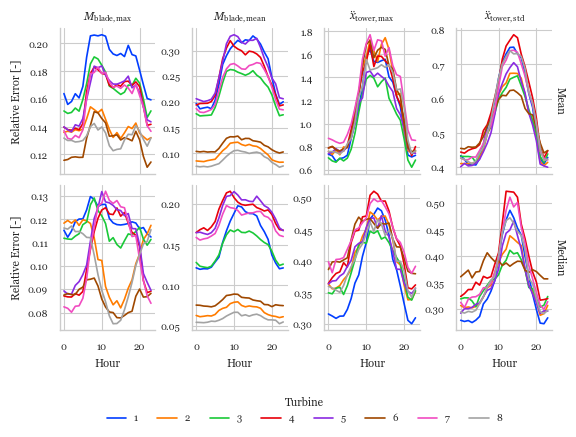

In [15]:
hour_plot(df_eval_blade_error_wo_z, df_eval_tower_error_wo_z)

### Error Correlation
The dependency of the prediction errors on specific variables, including all the features, is now
collectively investigated in a correlation plot. In addition to the four input features, the wind
direction has been added to aid with the identification of possible wake related prediction errors.

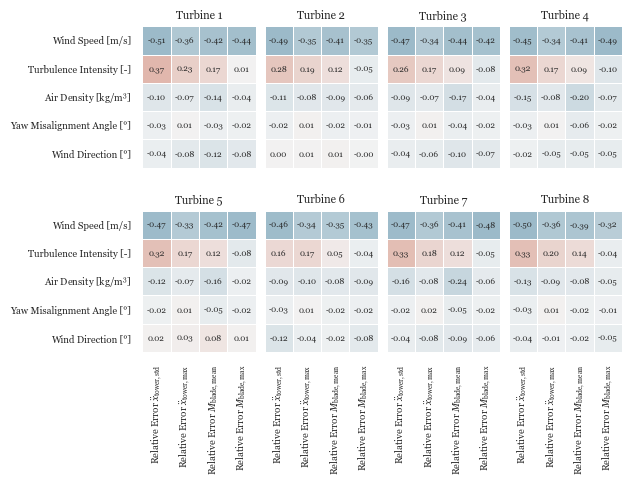

In [16]:
df_eval_tower_error_wide = long_to_wide(
    df_eval_tower_error_wo_z, 'variable', 'value')
df_eval_blade_error_wide = long_to_wide(
    df_eval_blade_error_wo_z, 'variable', 'value')

df_eval_tower_error_wide[df_eval_blade_error_wide.columns[-2:]] = df_eval_blade_error_wide.iloc[:, -2:]
df_eval_tower_error_wide.drop(columns=['Hour'], inplace=True)
fig_tower = corr_plots(df_eval_tower_error_wide)

### Seed to Seed Uncertainty
In assessing model performance, the z-score is employed to measure the deviation between the
predicted values and actual measurements in terms of the standard deviation due to the seed-to-
seed uncertainty. Generally, a lower z-score (e.g. below $3\sigma$) could suggest that a value falls within the expected range of the seed-to-seed uncertainty. Values larger than that would imply potential for improving prediction performance. 

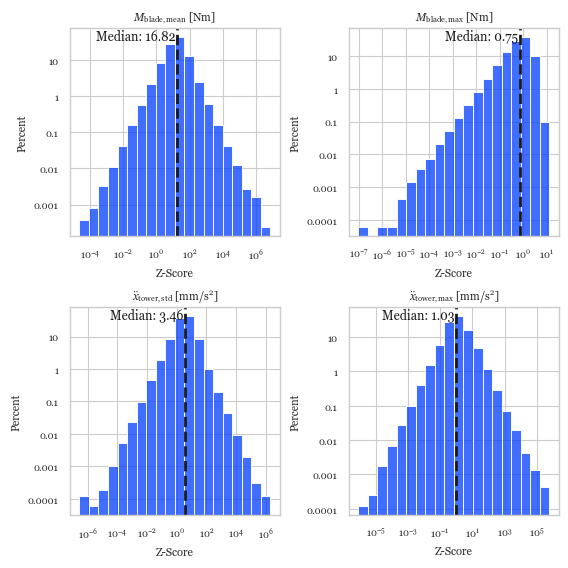

In [17]:
plot_error_significance(df_eval_blade_error, df_eval_tower_error, ['Blade_Mean', 'Blade_Max', 'Tower_Sdv', 'Tower_Max'])